# Convolutional Neural Network for clouds classification

In this notebook a basic Convolutional Neural Netowrk is used to classify pictures of clouds. </br>
The dataset used is available at: http://vintage.winklerbros.net/swimcat.html. </br>
From the original download folder, all the files have been removed so that the only ones left where subfolders, each one containing the respective pics. </br>

### Table of Contents
* [0 Imports](#chapter0)
* [1 Load and visualise data](#chapter1)
* [2 Preprocess data](#chapter2)
* [3 Create the Convolutional Neural Network](#chapter3)
* [4 Train the model](#chapter4)
* [5 Test the model](#chapter5)  

## 0. Imports <a class="anchor" id="chapter0"></a>

The packages used are: </br>
- `cv2` to read the RGB images
- `keras` for the neural network
- `sklearn` for the data splitting and performance evaluation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## 1. Load and visualise the data <a class="anchor" id="chapter1"></a>

In [2]:
# 'swimcat' is the name of the data folder 
data_dir = './swimcat'
# Names of the subfolders of the original dataset
categories = ['A-sky', 'B-pattern', 'C-thick-dark', 'D-thick-white', 'E-veil']

data = []
# for every subfolder
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    data_cat = []
    # for every image in the subfolder 
    for img in sorted(os.listdir(path)):
        filepath = os.path.join(path, img)
        # ignore the eventual .DS file
        try:
            # read the image 
            img_array = cv2.imread(filepath)
            # convert the image to RGB
            img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
            # one hot encode the class
            one_hot_category = to_categorical(i, 5)
            
            data_cat.append([img_array, one_hot_category])
        except:
            pass
        
    data.append(data_cat)

[0. 1. 0. 0. 0.]


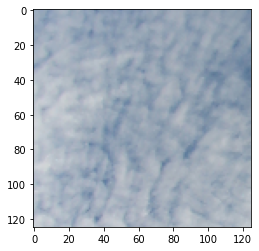

In [3]:
# Visualise some random outputa data
i = 1 # type of cloud
j = 10 # pic number
point = data[i][j]
img = point[0]
category = point[1]

print(category)
plt.imshow(img)

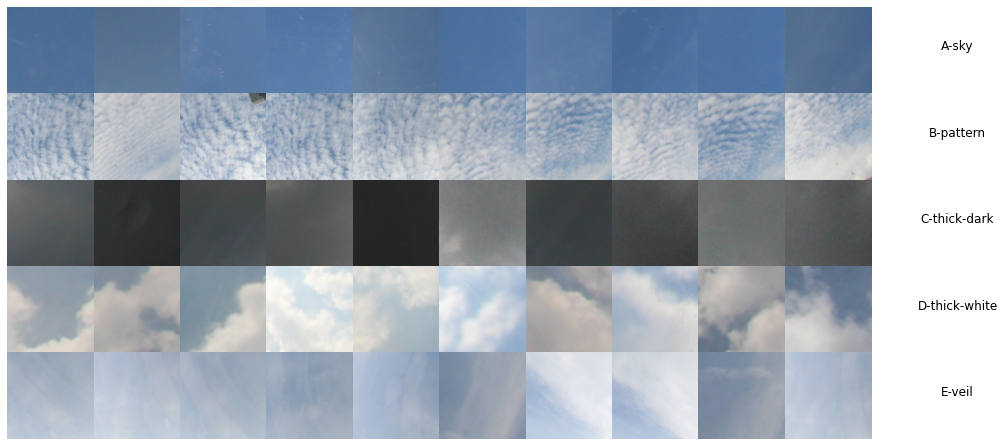

In [4]:
# Visualise some outputs

num_classes = len(categories) # rows
num_pics = 10 #columns

fig, ax = plt.subplots(num_classes, num_pics, figsize=(12, 6))

for i in range(num_classes):
    for j in range(num_pics):
        random_index = np.random.choice(len(data[i]), replace=False)
        point = data[i][random_index]
        img = point[0]
        
        ax[i][j].imshow(img)
        ax[i][j].axis('off')
        
    ax[i][j].text(2,0.5, categories[i], size=12, ha="center", transform=ax[i][j].transAxes)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()


## 2. Preprocess data <a class="anchor" id="chapter2"></a>

In [5]:
# since the dataset it's unbalanced, find the class with less samples
min_len = len(data[0])
for x in data:
    min_len = np.min([min_len, len(x)])

In [6]:
print(min_len)

85


In [7]:
# devide imgs and classes
X = []
y = []
for i in range(len(data)):
    # sample randomly min_len images from each folder
    indices = np.random.randint(len(data[i]), size=min_len)
    for j in indices:
        # add the pic
        X.append(data[i][j][0])
        # add the class
        y.append(data[i][j][1])

In [8]:
# normalize data
for i in range(len(X)):
    X[i] = X[i]/255

In [9]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# convert data to ndarray: necessary for full compatibility with keras
X_train =np.array([np.array(x) for x in X_train])
y_train =np.array([np.array(x) for x in y_train])

X_test =np.array([np.array(x) for x in X_test])
y_test =np.array([np.array(x) for x in y_test])

print(X_train.shape)
print(y_train.shape)

(297, 125, 125, 3)
(297, 5)


[0. 0. 0. 0. 1.]


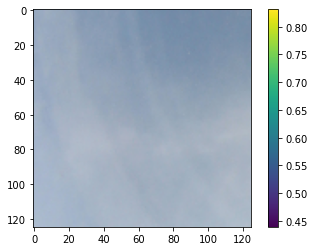

In [11]:
# plot normalized data
i = np.random.randint(len(X_train))
print(y_train[i])
plt.imshow(X_train[i])
# note that now the values are in [0, 1]
plt.colorbar()

## 3. Create the Convolutional Neural Network <a class="anchor" id="chapter3"></a>

Them model is taken from the following paper: https://www.koreascience.or.kr/article/JAKO201831854885763.pdf </br>
The model is a basic CNN, where a heavy amount of dropout is used. This is because the dataset is very small, and thus regularization is needed.

In [12]:
# shortcut for keras layers
layers = keras.layers

# create the model
model = keras.models.Sequential()

# input layer
model.add(layers.InputLayer(input_shape=(125, 125, 3)))

# convolutional part 
model.add(layers.Convolution2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Convolution2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Dropout(0.25))

model.add(layers.Convolution2D(16, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

# dense part
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation='relu'))

# output layer
model.add(layers.Dense(5, activation='softmax'))

# show summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 16)        0

In [13]:
# select optimizer, loss function, metric and compile the model
opt = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

## 4. Train the model <a class="anchor" id="chapter4"></a>

Note that 60 epochs have been used because, as can be tested, with more epochs the validation error start being constant, and only the training error keeps decreasing. This is known as overfitting, and it's thus useless trying to keep training the model further.

In [14]:
# train the model 
results = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=60,
                    verbose=2,
                    validation_split=0.1,
                    )

Epoch 1/60
5/5 - 3s - loss: 1.5966 - accuracy: 0.1910 - val_loss: 1.5680 - val_accuracy: 0.1333
Epoch 2/60
5/5 - 2s - loss: 1.5601 - accuracy: 0.2135 - val_loss: 1.5577 - val_accuracy: 0.3333
Epoch 3/60
5/5 - 2s - loss: 1.5253 - accuracy: 0.2322 - val_loss: 1.5155 - val_accuracy: 0.3000
Epoch 4/60
5/5 - 2s - loss: 1.5013 - accuracy: 0.2097 - val_loss: 1.5230 - val_accuracy: 0.4000
Epoch 5/60
5/5 - 3s - loss: 1.4312 - accuracy: 0.3596 - val_loss: 1.4396 - val_accuracy: 0.3333
Epoch 6/60
5/5 - 3s - loss: 1.3316 - accuracy: 0.3895 - val_loss: 1.3618 - val_accuracy: 0.3333
Epoch 7/60
5/5 - 3s - loss: 1.2078 - accuracy: 0.4157 - val_loss: 1.2373 - val_accuracy: 0.4333
Epoch 8/60
5/5 - 2s - loss: 1.1088 - accuracy: 0.4644 - val_loss: 1.1902 - val_accuracy: 0.4333
Epoch 9/60
5/5 - 2s - loss: 1.0533 - accuracy: 0.5655 - val_loss: 1.1236 - val_accuracy: 0.4667
Epoch 10/60
5/5 - 3s - loss: 1.0077 - accuracy: 0.5019 - val_loss: 1.1525 - val_accuracy: 0.4000
Epoch 11/60
5/5 - 2s - loss: 0.9466 - a

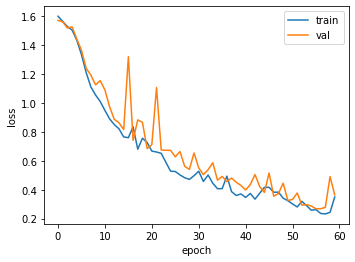

In [15]:
# plot train and validation error
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

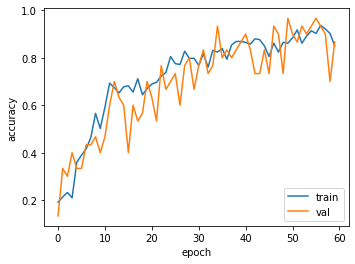

In [16]:
# plot train and validation accuracy 
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')

## 5. Test the model <a class="anchor" id="chapter5"></a>

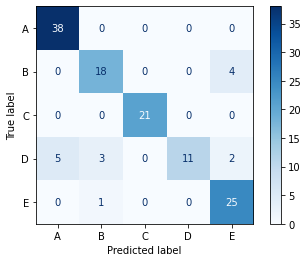

In [17]:
# predict values on the test set, x_set
y_pred = model.predict(X_test).round().squeeze()

# create confusion matrix with unseen data, y_test
classes = ['A', 'B', 'C', 'D', 'E']
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# display results
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()